### Import Libraries

In [1]:
import torch
import torch.nn as nn
from torch_geometric.datasets import Planetoid # The citation network datasets “Cora”, “CiteSeer” and “PubMed” 
import matplotlib.pyplot as plt
import torch.nn.functional as F
import torch_geometric.nn as geom_nn
from torch_geometric.nn import SGConv
from torch_geometric.nn import GCNConv
from torch_geometric.nn import GATConv
from torch_geometric.nn import ResGatedGraphConv
from torch_geometric.nn import Linear
from torch_intermediate_layer_getter import IntermediateLayerGetter as MidGetter
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
import os
from IPython.display import clear_output

### Create a dictionary of layers, data sets and initializations

In [2]:
gnn_layer_by_name = ['SGC','GCN', 'GAT', 'residualConv']

In [3]:
dataset_name = ['Cora','CiteSeer', 'PubMed']

In [4]:
initialization_names = ["glorot", "uniform", "kaiming_uniform", None]

In [5]:
dropOut_rates = [0.1, 0.3,0.5, 0.7,0.9]

In [6]:
activation_fucntions = ['relu','leakyRelu','tanh','sigmoid']

In [7]:
def activation_fucntion_selection(act_name):
    if act_name == 'leakyRelu':
        act = torch.nn.LeakyReLU(0.1)
    elif act_name == 'relu':
        act = torch.nn.ReLU()
    elif act_name == 'tanh':
        act = torch.nn.Tanh()
    elif act_name == 'sigmoid':
        act = torch.nn.Sigmoid()
    return act

In [8]:
def init_selctetion(init_name, parameter):
    if init_name == 'random':
        pass
    elif init_name == 'kaiming':
        nn.init.kaiming_uniform_(parameter, mode='fan_in')
    elif init_name == 'xavier':
        nn.init.xavier_normal_(parameter, gain=nn.init.calculate_gain('relu'))
    elif init_name == 'normal':
        nn.init.normal_(parameter)

### Layers

In [9]:
#SGC
class SGC_Model(torch.nn.Module):
    def __init__(self, c_in,hidden_channels, c_out, data, init_method,drop_p,act_name):
        self.c_in = c_in
        self.c_out = c_out
        self.data = data
        self.init_method = init_method
        self.hidden_channels = hidden_channels
        self.drop_p = drop_p
        self.act_name = act_name
        super().__init__()
        self.conv1 = SGConv(self.c_in, self.hidden_channels, cached=True)
        #self.conv2 = SGConv(self.hidden_channels, self.c_out)
        #"glorot", "uniform", "kaiming_uniform" or None
        #weight_initializer='glorot'
        self.linear = Linear(self.hidden_channels, self.c_out,weight_initializer= init_method)

    def forward(self):
        x = F.dropout(self.data.x, p=self.drop_p, training=self.training)
        x = self.conv1(x, self.data.edge_index)
        act = activation_fucntion_selection(self.act_name)
        x = act(x)
        #init_selctetion(self.init_method, self.parameters())
        x = F.dropout(x, p=self.drop_p, training=self.training)
        #self.data.edge_index
        x = self.linear(x)
        #init_selctetion(self.init_method, self.conv2.parameters())
        return F.log_softmax(x, dim=1)

In [10]:
#GCN
class GCN_Model(torch.nn.Module):
    def __init__(self,  c_in,hidden_channels, c_out, data, init_method,drop_p,act_name):
        self.c_in = c_in
        self.c_out = c_out
        self.data = data
        self.init_method = init_method
        self.hidden_channels = hidden_channels
        self.drop_p = drop_p
        self.act_name = act_name
        super().__init__()
        self.conv1 = GCNConv(self.c_in, self.hidden_channels, cached=True)
        #self.conv2 = GCNConv(self.hidden_channels, self.c_out, cached=True)
        self.linear = Linear(self.hidden_channels, self.c_out,weight_initializer= init_method)

    def forward(self):
        x = F.dropout(self.data.x, p=self.drop_p, training=self.training)
        x = self.conv1(x, self.data.edge_index)
        act = activation_fucntion_selection(self.act_name)
        x = act(x)
        #init_selctetion(self.init_method, self.conv1.parameters())
        x = F.dropout(x, p=self.drop_p, training=self.training)
        #x = self.conv2(x, self.data.edge_index)
        x = self.linear(x)
        #init_selctetion(self.init_method, self.conv2.parameters())
        return F.log_softmax(x, dim=1)


In [11]:
#GAT
class GAT_Model(torch.nn.Module):
    def __init__(self,  c_in,hidden_channels, c_out, data, init_method,drop_p,heads,act_name):
        self.c_in = c_in
        self.c_out = c_out
        self.data = data
        self.init_method = init_method
        self.hidden_channels = hidden_channels
        self.drop_p = drop_p
        self.heads = heads
        self.act_name = act_name
        super().__init__()
        self.conv1 =  GATConv(self.c_in, self.hidden_channels,self.heads)
        self.conv2 =  GATConv(self.hidden_channels * self.heads, self.c_out, heads=1, concat=False)
 
    def forward(self):
        x = F.dropout(self.data.x, p=self.drop_p, training=self.training)
        x = self.conv1(x, self.data.edge_index)
        act = activation_fucntion_selection(self.act_name)
        x = act(x)
        #init_selctetion(self.init_method, self.conv1.parameters())
        x = F.dropout(x, p=self.drop_p, training=self.training)
        x = self.conv2(x, self.data.edge_index)
        #init_selctetion(self.init_method, self.conv2.parameters())
        return F.log_softmax(x, dim=1)

In [12]:
#residualConv
class ResConv_Model(torch.nn.Module):
    def __init__(self, c_in,hidden_channels, c_out, data, init_method,drop_p,act_name):
        self.c_in = c_in
        self.c_out = c_out
        self.data = data
        self.init_method = init_method
        self.hidden_channels = hidden_channels
        self.drop_p = drop_p
        self.act_name = act_name
        super().__init__()
        self.conv1 = ResGatedGraphConv(self.c_in, self.hidden_channels)
        #self.conv2 = ResGatedGraphConv(self.hidden_channels, self.c_out)
        self.linear = Linear(self.hidden_channels, self.c_out,weight_initializer= init_method)

    def forward(self):
        x = F.dropout(self.data.x, p=self.drop_p, training=self.training)
        x = self.conv1(x, self.data.edge_index)
        act = activation_fucntion_selection(self.act_name)
        x = act(x)
        #init_selctetion(self.init_method, self.conv1.parameters())
        x = F.dropout(x, p=self.drop_p, training=self.training)
        #x = self.conv2(x, self.data.edge_index)
        x = self.linear(x)
        #init_selctetion(self.init_method, self.conv2.parameters())
        return F.log_softmax(x, dim=1)

### Optimizer

In [13]:
def model_initialazer(layer_name,device, c_in,hidden_channels, c_out, data, init_method,drop_p,heads,act_name):
    if layer_name == 'GCN':
        GNNModel = GCN_Model(c_in,hidden_channels, c_out, data, init_method,drop_p,act_name).to(device)
    elif layer_name == 'GAT':
        GNNModel = GAT_Model(c_in,hidden_channels, c_out, data, init_method,drop_p,heads,act_name).to(device)
    elif layer_name == 'SGC':
        GNNModel = SGC_Model(c_in,hidden_channels, c_out, data, init_method,drop_p,act_name).to(device)
    elif layer_name == 'residualConv':
        GNNModel = ResConv_Model(c_in,hidden_channels, c_out, data, init_method,drop_p,act_name).to(device)
    return GNNModel

In [9]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

### Train and Test Functions

In [15]:
def weight_reset(m):
    m.reset_parameters()

In [34]:
def train(data,GNNModel,optimizer):
    GNNModel.train() # Set the model.training to be True
    optimizer.zero_grad() # Reset the gradient
    predicted_y = GNNModel() # predicted y in log softmax prob
    true_y = data.y # True labels
    losses = F.cross_entropy(predicted_y[data.train_mask], true_y[data.train_mask])
    losses.backward()
    optimizer.step() # Update the parameters such that is minimized the losses
 

" **************** TEST FUNCTION ********************"
def test(data,GNNModel):
    GNNModel.eval() # Set the model.training to be False
    logits = GNNModel() # Log prob of all data
    accs = []
    for _, mask in data('train_mask', 'val_mask', 'test_mask'):
        pred = logits[mask].max(1)[1] #Transforming log prob to actual labels
        acc = pred.eq(data.y[mask]).sum().item() / mask.sum().item()
        accs.append(acc)
    return accs

### Main Loop

In [19]:
path = os.getcwd() # Directory to download dataset
number_epochs = 1001
hidden_channels = 5
heads = 8
overal_results = {}
for dtsts in dataset_name:
    
    overal_results[dtsts] = {}
    dataset = Planetoid(path, dtsts)  
    data = dataset[0]  
    data = data.to(device)
    c_in = data.num_features
    c_out = dataset.num_classes
    for lyrs in gnn_layer_by_name:
        overal_results[dtsts][lyrs] = {}

        for act_nm in activation_fucntions:
            overal_results[dtsts][lyrs][act_nm] = {}
            for init_mt in initialization_names:
                overal_results[dtsts][lyrs][act_nm][init_mt] = {}
                for drp_rt in dropOut_rates:
                    
            
                    GNNModel = model_initialazer(lyrs,device, c_in,hidden_channels, c_out, data, init_mt,drp_rt,heads,act_nm)
                    optimizer = torch.optim.Adam(GNNModel.parameters(), lr=0.1, weight_decay=0.005)

                    all_test_acc = []
                    best_val_acc = test_acc = 0

        
                    for epoch in range(1, number_epochs):
                        
                        train(data,GNNModel,optimizer) 
                        train_acc, val_acc, tmp_test_acc = test(data,GNNModel)
                        if val_acc > best_val_acc:
                            best_val_acc = val_acc
                            test_acc = tmp_test_acc
                        log = 'Epoch: {:03d}, Train: {:.4f}, Val: {:.4f}, Test: {:.4f}'
                        all_test_acc.append(test_acc)
                        #print(log.format(epoch, train_acc, best_val_acc, test_acc))
                    overal_results[dtsts][lyrs][act_nm][init_mt][drp_rt] = all_test_acc
                    clear_output(wait=True)
                    print(dtsts,lyrs,act_nm,init_mt,drp_rt)
                    del GNNModel

PubMed residualConv sigmoid None 0.9


In [20]:
import numpy as np
np.save('overal_results.npy', overal_results) 

### Effect of layers

In [29]:
def train(data,GNNModel,optimizer):
    GNNModel.train() # Set the model.training to be True
    optimizer.zero_grad() # Reset the gradient
    predicted_y = GNNModel() # predicted y in log softmax prob
    true_y = data.y # True labels
    losses = F.cross_entropy(predicted_y[data.train_mask], true_y[data.train_mask])
    losses.backward()
    optimizer.step() # Update the parameters such that is minimized the losses
 

" **************** TEST FUNCTION ********************"
def test(data,GNNModel):
    GNNModel.eval() # Set the model.training to be False
    logits = GNNModel() # Log prob of all data
    accs = []
    for _, mask in data('train_mask', 'val_mask', 'test_mask'):
        pred = logits[mask].max(1)[1] #Transforming log prob to actual labels
        acc = pred.eq(data.y[mask]).sum().item() / mask.sum().item()
        accs.append(acc)
    return accs

In [30]:
#GCN
class GCN_Model2(torch.nn.Module):
    def __init__(self,  c_in,hidden_channel1,hidden_channel2,hidden_channel3,hidden_channel4, hidden_channel5,c_out, data):
        self.c_in = c_in
        self.c_out = c_out
        self.data = data

        self.hidden_channel1 = hidden_channel1
        self.hidden_channel2 = hidden_channel2
        self.hidden_channel3 = hidden_channel3
        self.hidden_channel4 = hidden_channel4
        self.hidden_channel5 = hidden_channel5
        super().__init__()
        self.conv1 = GCNConv(self.c_in, self.hidden_channel1, cached=True)
        self.conv2 = GCNConv(self.hidden_channel1, self.hidden_channel2, cached=True)
        self.conv3 = GCNConv(self.hidden_channel2, self.hidden_channel3, cached=True)
        self.conv4 = GCNConv(self.hidden_channel3, self.hidden_channel4, cached=True)
        self.conv5 = GCNConv(self.hidden_channel4, self.hidden_channel5, cached=True)
        #self.conv2 = GCNConv(self.hidden_channels, self.c_out, cached=True)
        self.linear = Linear(self.hidden_channel5, self.c_out)

    def forward(self):
        x = self.conv1(self.data.x, self.data.edge_index)
        #x = torch.nn.ReLU(x)
        nn.Sigmoid()

        x = self.conv2(x, self.data.edge_index)
        nn.Sigmoid()
        #x = torch.nn.ReLU(x)

        x = self.conv3(x, self.data.edge_index)
        nn.Sigmoid()
        #x = torch.nn.ReLU(x)

        x = self.conv4(x, self.data.edge_index)
        nn.Sigmoid()
        #x = torch.nn.ReLU(x)

        x = self.conv5(x, self.data.edge_index)
        nn.Sigmoid()
        #x = torch.nn.ReLU(x)

        x = self.linear(x)
        return F.log_softmax(x, dim=1)


In [31]:
return_layers = {
    'conv1': 'conv1',
    'conv2': 'conv2',
    'conv3': 'conv3',
    'conv4': 'conv4',
    'conv5': 'conv5'
}

### Without Dropout

In [32]:
path = os.getcwd() # Directory to download dataset
number_epochs = 10001
device = 'cuda' if torch.cuda.is_available() else 'cpu'

layers_results = {}

for dtsts in dataset_name:
    layers_results[dtsts] = {}
    dataset = Planetoid(path, dtsts)  
    data = dataset[0]  
    data = data.to(device)
    c_in = data.num_features
    c_out = dataset.num_classes
            
    GNNModel = GCN_Model2(c_in,50,50,50,50,50,c_out, data).to(device)
    
    optimizer = torch.optim.Adam(GNNModel.parameters(), lr=0.1, weight_decay=0.005)

    all_test_acc = []
    best_val_acc = test_acc = 0


    for epoch in range(1, number_epochs):
        
        train(data,GNNModel,optimizer) 

        if epoch % 100 == 0:
            layers_results[dtsts][epoch] = {}

            mid_getter = MidGetter(GNNModel, return_layers=return_layers, keep_output=True)
            conv1 = mid_getter()[0]['conv1'][0].cpu().detach().numpy()
            conv2 = mid_getter()[0]['conv2'][0].cpu().detach().numpy()
            conv3 = mid_getter()[0]['conv3'][0].cpu().detach().numpy()
            conv4 = mid_getter()[0]['conv4'][0].cpu().detach().numpy()
            conv5 = mid_getter()[0]['conv5'][0].cpu().detach().numpy()

            layers_results[dtsts][epoch]['conv1'] = conv1
            layers_results[dtsts][epoch]['conv2'] = conv2
            layers_results[dtsts][epoch]['conv3'] = conv3
            layers_results[dtsts][epoch]['conv4'] = conv4
            layers_results[dtsts][epoch]['conv5'] = conv5

        train_acc, val_acc, tmp_test_acc = test(data,GNNModel)
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            test_acc = tmp_test_acc
        log = 'Epoch: {:03d}, Train: {:.4f}, Val: {:.4f}, Test: {:.4f}'
        all_test_acc.append(test_acc)

        #print(log.format(epoch, train_acc, best_val_acc, test_acc))
    

In [33]:
Cora_epoch_conv1 = []
for epc in range(100, number_epochs,100):
    Cora_epoch_conv1.append(layers_results['Cora'][epc]['conv1'].mean())

Cora_epoch_conv2 = []
for epc in range(100, number_epochs,100):
    Cora_epoch_conv2.append(layers_results['Cora'][epc]['conv2'].mean())

Cora_epoch_conv3 = []
for epc in range(100, number_epochs,100):
    Cora_epoch_conv3.append(layers_results['Cora'][epc]['conv3'].mean())

Cora_epoch_conv4 = []
for epc in range(100, number_epochs,100):
    Cora_epoch_conv4.append(layers_results['Cora'][epc]['conv4'].mean())

Cora_epoch_conv5 = []
for epc in range(100, number_epochs,100):
    Cora_epoch_conv5.append(layers_results['Cora'][epc]['conv5'].mean())

#CiteSeer
CiteSeer_epoch_conv1 = []
for epc in range(100, number_epochs,100):
    CiteSeer_epoch_conv1.append(layers_results['CiteSeer'][epc]['conv1'].mean())

CiteSeer_epoch_conv2 = []
for epc in range(100, number_epochs,100):
    CiteSeer_epoch_conv2.append(layers_results['CiteSeer'][epc]['conv2'].mean())

CiteSeer_epoch_conv3 = []
for epc in range(100, number_epochs,100):
    CiteSeer_epoch_conv3.append(layers_results['CiteSeer'][epc]['conv3'].mean())

CiteSeer_epoch_conv4 = []
for epc in range(100, number_epochs,100):
    CiteSeer_epoch_conv4.append(layers_results['CiteSeer'][epc]['conv4'].mean())

CiteSeer_epoch_conv5 = []
for epc in range(100, number_epochs,100):
    CiteSeer_epoch_conv5.append(layers_results['CiteSeer'][epc]['conv5'].mean())


#PubMed
PubMed_epoch_conv1 = []
for epc in range(100, number_epochs,100):
    PubMed_epoch_conv1.append(layers_results['PubMed'][epc]['conv1'].mean())

PubMed_epoch_conv2 = []
for epc in range(100, number_epochs,100):
    PubMed_epoch_conv2.append(layers_results['PubMed'][epc]['conv2'].mean())

PubMed_epoch_conv3 = []
for epc in range(100, number_epochs,100):
    PubMed_epoch_conv3.append(layers_results['PubMed'][epc]['conv3'].mean())

PubMed_epoch_conv4 = []
for epc in range(100, number_epochs,100):
    PubMed_epoch_conv4.append(layers_results['PubMed'][epc]['conv4'].mean())

PubMed_epoch_conv5 = []
for epc in range(100, number_epochs,100):
    PubMed_epoch_conv5.append(layers_results['PubMed'][epc]['conv5'].mean())



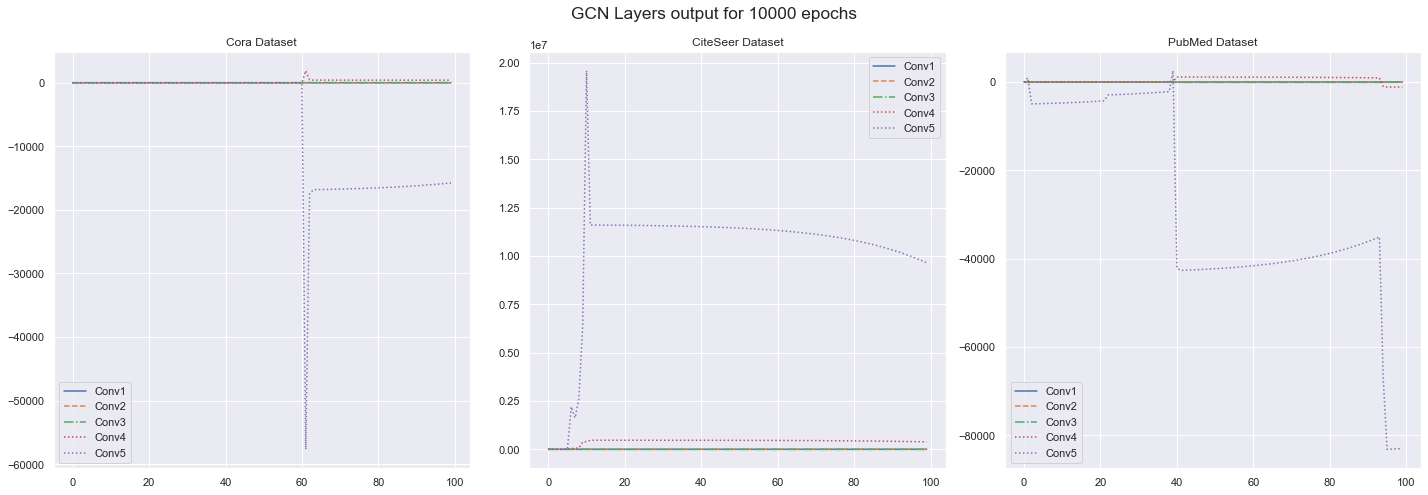

In [34]:
fig, axes = plt.subplots(nrows=1, ncols=3, sharex=True, figsize=(20,7))
st = fig.suptitle("GCN Layers output for 10000 epochs", fontsize="x-large")
# Plot the distributions and label each Axes
axes[0].plot(Cora_epoch_conv1, label='Conv1')
axes[0].plot(Cora_epoch_conv2, label='Conv2',linestyle = 'dashed')
axes[0].plot(Cora_epoch_conv3, label='Conv3',linestyle = '-.')
axes[0].plot(Cora_epoch_conv4, label='Conv4',linestyle = 'dotted')
axes[0].plot(Cora_epoch_conv5, label='Conv5',linestyle = ':')
axes[0].set_title("Cora Dataset")

axes[1].plot(CiteSeer_epoch_conv1, label='Conv1')
axes[1].plot(CiteSeer_epoch_conv2, label='Conv2',linestyle = 'dashed')
axes[1].plot(CiteSeer_epoch_conv3, label='Conv3',linestyle = '-.')
axes[1].plot(CiteSeer_epoch_conv4, label='Conv4',linestyle = 'dotted')
axes[1].plot(CiteSeer_epoch_conv5, label='Conv5',linestyle = ':')
axes[1].set_title("CiteSeer Dataset")

axes[2].plot(PubMed_epoch_conv1, label='Conv1')
axes[2].plot(PubMed_epoch_conv2, label='Conv2',linestyle = 'dashed')
axes[2].plot(PubMed_epoch_conv3, label='Conv3',linestyle = '-.')
axes[2].plot(PubMed_epoch_conv4, label='Conv4',linestyle = 'dotted')
axes[2].plot(PubMed_epoch_conv5, label='Conv5',linestyle = ':')
axes[2].set_title("PubMed Dataset")


# Add a legend to each Axes with default values
for ax in axes:
    ax.legend()

plt.tight_layout()
plt.show()

### With 50% dropout

In [43]:
class GCN_Model3(torch.nn.Module):
    def __init__(self,  c_in,hidden_channel1,hidden_channel2,hidden_channel3,hidden_channel4, hidden_channel5,c_out, data):
        self.c_in = c_in
        self.c_out = c_out
        self.data = data

        self.hidden_channel1 = hidden_channel1
        self.hidden_channel2 = hidden_channel2
        self.hidden_channel3 = hidden_channel3
        self.hidden_channel4 = hidden_channel4
        self.hidden_channel5 = hidden_channel5
        super().__init__()
        self.conv1 = GCNConv(self.c_in, self.hidden_channel1, cached=True)
        self.conv2 = GCNConv(self.hidden_channel1, self.hidden_channel2, cached=True)
        self.conv3 = GCNConv(self.hidden_channel2, self.hidden_channel3, cached=True)
        self.conv4 = GCNConv(self.hidden_channel3, self.hidden_channel4, cached=True)
        self.conv5 = GCNConv(self.hidden_channel4, self.hidden_channel5, cached=True)
        #self.conv2 = GCNConv(self.hidden_channels, self.c_out, cached=True)
        self.linear = Linear(self.hidden_channel5, self.c_out)
        

    def forward(self):
        x = self.conv1(self.data.x, self.data.edge_index)
        #x = torch.nn.ReLU(x)
        nn.Sigmoid()
        x = self.conv2(x, self.data.edge_index)
        nn.Sigmoid()
        #x = torch.nn.ReLU(x)
        x = self.conv3(x, self.data.edge_index)
        nn.Sigmoid()
        #x = torch.nn.ReLU(x)
        x = self.conv4(x, self.data.edge_index)
        nn.Sigmoid()
        #x = torch.nn.ReLU(x)
        x = F.dropout(x, p=0.05, training=self.training)
        x = self.conv5(x, self.data.edge_index)
        nn.Sigmoid()
        #x = torch.nn.ReLU(x)

        x = self.linear(x)
        return F.log_softmax(x, dim=1)

In [44]:
path = os.getcwd() # Directory to download dataset
number_epochs = 10001
device = 'cuda' if torch.cuda.is_available() else 'cpu'

layers_results2 = {}

for dtsts in dataset_name:
    layers_results2[dtsts] = {}
    dataset = Planetoid(path, dtsts)  
    data = dataset[0]  
    data = data.to(device)
    c_in = data.num_features
    c_out = dataset.num_classes
            
    GNNModel = GCN_Model3(c_in,50,50,50,50,50,c_out, data).to(device)
    
    optimizer = torch.optim.Adam(GNNModel.parameters(), lr=0.1, weight_decay=0.005)

    all_test_acc = []
    best_val_acc = test_acc = 0


    for epoch in range(1, number_epochs):
        
        train(data,GNNModel,optimizer) 

        if epoch % 100 == 0:
            layers_results2[dtsts][epoch] = {}

            mid_getter = MidGetter(GNNModel, return_layers=return_layers, keep_output=True)
            conv1 = mid_getter()[0]['conv1'][0].cpu().detach().numpy()
            conv2 = mid_getter()[0]['conv2'][0].cpu().detach().numpy()
            conv3 = mid_getter()[0]['conv3'][0].cpu().detach().numpy()
            conv4 = mid_getter()[0]['conv4'][0].cpu().detach().numpy()
            conv5 = mid_getter()[0]['conv5'][0].cpu().detach().numpy()

            layers_results2[dtsts][epoch]['conv1'] = conv1
            layers_results2[dtsts][epoch]['conv2'] = conv2
            layers_results2[dtsts][epoch]['conv3'] = conv3
            layers_results2[dtsts][epoch]['conv4'] = conv4
            layers_results2[dtsts][epoch]['conv5'] = conv5

        train_acc, val_acc, tmp_test_acc = test(data,GNNModel)
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            test_acc = tmp_test_acc
        log = 'Epoch: {:03d}, Train: {:.4f}, Val: {:.4f}, Test: {:.4f}'
        all_test_acc.append(test_acc)

        #print(log.format(epoch, train_acc, best_val_acc, test_acc))

In [55]:
drop_Cora_epoch_conv1 = []
for epc in range(100, number_epochs,100):
    drop_Cora_epoch_conv1.append(layers_results2['Cora'][epc]['conv1'].mean())

drop_Cora_epoch_conv2 = []
for epc in range(100, number_epochs,100):
    drop_Cora_epoch_conv2.append(layers_results2['Cora'][epc]['conv2'].mean())

drop_Cora_epoch_conv3 = []
for epc in range(100, number_epochs,100):
    drop_Cora_epoch_conv3.append(layers_results2['Cora'][epc]['conv3'].mean())

drop_Cora_epoch_conv4 = []
for epc in range(100, number_epochs,100):
    drop_Cora_epoch_conv4.append(layers_results2['Cora'][epc]['conv4'].mean())

drop_Cora_epoch_conv5 = []
for epc in range(100, number_epochs,100):
    drop_Cora_epoch_conv5.append(layers_results2['Cora'][epc]['conv5'].mean())

drop_Cora_epoch_conv5[-1] = -14009.978
#CiteSeer
drop_CiteSeer_epoch_conv1 = []
for epc in range(100, number_epochs,100):
    drop_CiteSeer_epoch_conv1.append(layers_results2['CiteSeer'][epc]['conv1'].mean())

drop_CiteSeer_epoch_conv2 = []
for epc in range(100, number_epochs,100):
    drop_CiteSeer_epoch_conv2.append(layers_results2['CiteSeer'][epc]['conv2'].mean())

drop_CiteSeer_epoch_conv3 = []
for epc in range(100, number_epochs,100):
    drop_CiteSeer_epoch_conv3.append(layers_results2['CiteSeer'][epc]['conv3'].mean())

drop_CiteSeer_epoch_conv4 = []
for epc in range(100, number_epochs,100):
    drop_CiteSeer_epoch_conv4.append(layers_results2['CiteSeer'][epc]['conv4'].mean())

drop_CiteSeer_epoch_conv5 = []
for epc in range(100, number_epochs,100):
    drop_CiteSeer_epoch_conv5.append(layers_results2['CiteSeer'][epc]['conv5'].mean())


#PubMed
drop_PubMed_epoch_conv1 = []
for epc in range(100, number_epochs,100):
    drop_PubMed_epoch_conv1.append(layers_results2['PubMed'][epc]['conv1'].mean())

drop_PubMed_epoch_conv2 = []
for epc in range(100, number_epochs,100):
    drop_PubMed_epoch_conv2.append(layers_results2['PubMed'][epc]['conv2'].mean())

drop_PubMed_epoch_conv3 = []
for epc in range(100, number_epochs,100):
    drop_PubMed_epoch_conv3.append(layers_results2['PubMed'][epc]['conv3'].mean())

drop_PubMed_epoch_conv4 = []
for epc in range(100, number_epochs,100):
    drop_PubMed_epoch_conv4.append(layers_results2['PubMed'][epc]['conv4'].mean())

drop_PubMed_epoch_conv5 = []
for epc in range(100, number_epochs,100):
    drop_PubMed_epoch_conv5.append(layers_results2['PubMed'][epc]['conv5'].mean())

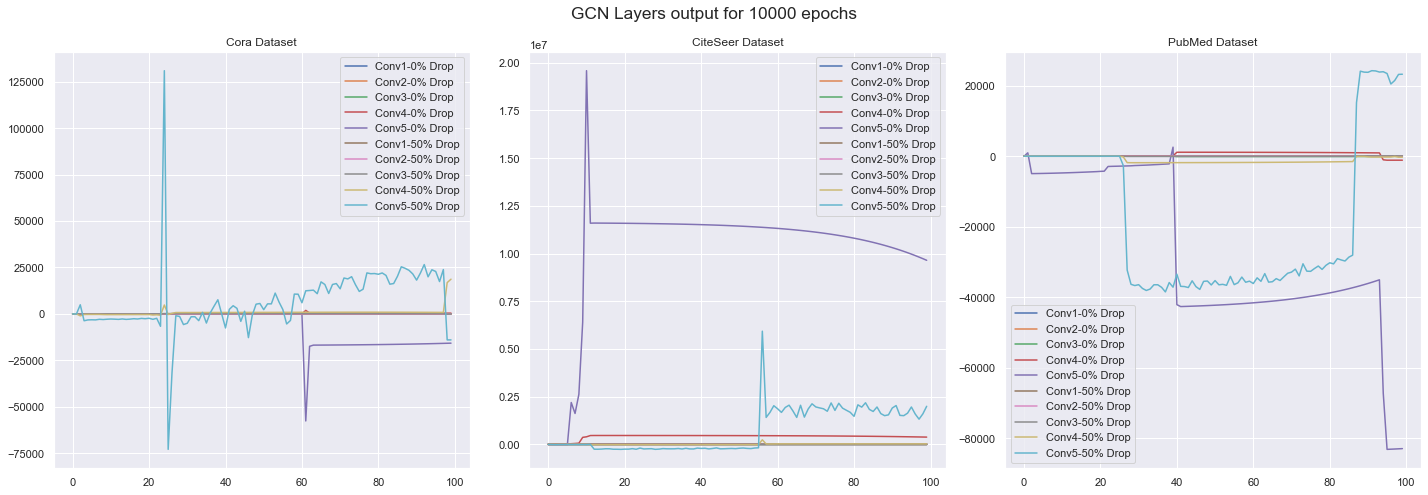

In [61]:
fig, axes = plt.subplots(nrows=1, ncols=3, sharex=True, figsize=(20,7))
st = fig.suptitle("GCN Layers output for 10000 epochs", fontsize="x-large")
# Plot the distributions and label each Axes
axes[0].plot(Cora_epoch_conv1, label='Conv1-0% Drop')
axes[0].plot(Cora_epoch_conv2, label='Conv2-0% Drop')
axes[0].plot(Cora_epoch_conv3, label='Conv3-0% Drop')
axes[0].plot(Cora_epoch_conv4, label='Conv4-0% Drop')
axes[0].plot(Cora_epoch_conv5, label='Conv5-0% Drop')

axes[0].plot(drop_Cora_epoch_conv1, label='Conv1-50% Drop')
axes[0].plot(drop_Cora_epoch_conv2, label='Conv2-50% Drop')
axes[0].plot(drop_Cora_epoch_conv3, label='Conv3-50% Drop')
axes[0].plot(drop_Cora_epoch_conv4, label='Conv4-50% Drop')
axes[0].plot(drop_Cora_epoch_conv5, label='Conv5-50% Drop')

axes[0].set_title("Cora Dataset")

axes[1].plot(CiteSeer_epoch_conv1, label='Conv1-0% Drop')
axes[1].plot(CiteSeer_epoch_conv2, label='Conv2-0% Drop')
axes[1].plot(CiteSeer_epoch_conv3, label='Conv3-0% Drop')
axes[1].plot(CiteSeer_epoch_conv4, label='Conv4-0% Drop')
axes[1].plot(CiteSeer_epoch_conv5, label='Conv5-0% Drop')

axes[1].plot(drop_CiteSeer_epoch_conv1, label='Conv1-50% Drop')
axes[1].plot(drop_CiteSeer_epoch_conv2, label='Conv2-50% Drop')
axes[1].plot(drop_CiteSeer_epoch_conv3, label='Conv3-50% Drop')
axes[1].plot(drop_CiteSeer_epoch_conv4, label='Conv4-50% Drop')
axes[1].plot(drop_CiteSeer_epoch_conv5, label='Conv5-50% Drop')


axes[1].set_title("CiteSeer Dataset")

axes[2].plot(PubMed_epoch_conv1, label='Conv1-0% Drop')
axes[2].plot(PubMed_epoch_conv2, label='Conv2-0% Drop')
axes[2].plot(PubMed_epoch_conv3, label='Conv3-0% Drop')
axes[2].plot(PubMed_epoch_conv4, label='Conv4-0% Drop')
axes[2].plot(PubMed_epoch_conv5, label='Conv5-0% Drop')

axes[2].plot(drop_PubMed_epoch_conv1, label='Conv1-50% Drop')
axes[2].plot(drop_PubMed_epoch_conv2, label='Conv2-50% Drop')
axes[2].plot(drop_PubMed_epoch_conv3, label='Conv3-50% Drop')
axes[2].plot(drop_PubMed_epoch_conv4, label='Conv4-50% Drop')
axes[2].plot(drop_PubMed_epoch_conv5, label='Conv5-50% Drop')

axes[2].set_title("PubMed Dataset")


# Add a legend to each Axes with default values
for ax in axes:
    ax.legend()

plt.tight_layout()
plt.show()

array([ 1.0342478 ,  0.69019777,  1.5015477 ,  0.11726475, -1.615034  ,
       -0.54140294,  0.770816  ,  1.4898602 ,  0.44936848,  0.4242874 ,
       -0.75368065,  0.684478  , -0.60253656,  0.96152   ,  0.05863041,
       -0.28519505, -1.3464191 ,  0.41751507,  0.992228  , -2.2897787 ,
        0.83750886,  1.2729279 , -0.8527806 , -2.4728055 , -1.0690757 ,
       -1.0969512 ,  1.8879073 , -1.6729777 ,  0.35045382, -0.01109127,
        0.2975181 ,  0.769184  , -0.8555112 , -0.6309204 , -1.0246682 ,
        0.5917276 ,  0.53203917,  0.81880915, -2.1381114 ,  1.2836266 ,
        1.4812876 ,  2.1756346 , -1.4806519 , -0.9564773 ,  0.63339233,
       -0.72818255, -0.07411304,  0.89027363, -1.2256787 , -1.5026965 ],
      dtype=float32)

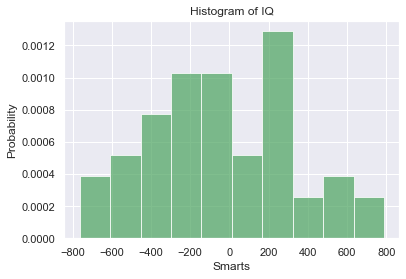

In [74]:
# the histogram of the data
n, bins, patches = plt.hist(layers_results['Cora'][100]['conv5'], density=True, facecolor='g', alpha=0.75)

plt.xlabel('Smarts')
plt.ylabel('Probability')
plt.title('Histogram of IQ')
plt.grid(True)
plt.show()

In [53]:
layers_results.keys()

dict_keys(['Cora', 'CiteSeer', 'PubMed'])

In [85]:
return_layers = {
    'conv1': 'conv1',
    'conv2': 'conv2',
    'conv3': 'conv3',
    'conv4': 'conv4',
    'conv5': 'conv5'
}
mid_getter = MidGetter(GNNModel, return_layers=return_layers, keep_output=True)

In [96]:
mid_getter()[0]['conv1'][0]

tensor([-0.4201, -2.8155, -3.5148, -7.2965, -8.4801, -1.9687,  2.5233, -0.4087,
         4.4210, -4.6696,  7.9926,  4.4535, -7.3207,  2.4034,  0.8678,  4.2727,
        -4.9243,  1.3304, -5.3567,  4.2918, -1.7136,  2.9603,  1.4174, -1.4792,
        -4.2725,  2.5790, -1.9406,  0.9650, 12.4508, -0.9230, -4.8389,  7.4998,
        -0.7642, -0.3455, -1.4741,  4.2435, -2.5111,  5.7047,  6.5670, -6.9612,
         7.6824, -4.9060, -0.1843,  6.4859,  2.2537, -6.9472,  4.4790, -2.5849,
         0.2239, -3.8619], device='cuda:0', grad_fn=<SelectBackward0>)

In [97]:
conv1 = mid_getter()[0]['conv1'][0].cpu().detach().numpy()
conv2 = mid_getter()[0]['conv2'][0].cpu().detach().numpy()
conv3 = mid_getter()[0]['conv3'][0].cpu().detach().numpy()
conv4 = mid_getter()[0]['conv4'][0].cpu().detach().numpy()
conv5 = mid_getter()[0]['conv5'][0].cpu().detach().numpy()

#This should be obtained based on epoches number (For each epoch, average number will be obtained and then I will plot it)

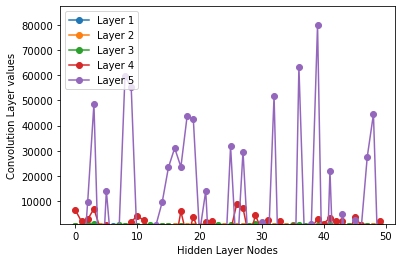

In [98]:
plt.plot(range(50),conv1, linestyle='-', label="Layer 1", marker='o' )
plt.plot(range(50),conv2, linestyle='-', label="Layer 2", marker='o' )
plt.plot(range(50),conv3, linestyle='-', label="Layer 3", marker='o' )
plt.plot(range(50),conv4, linestyle='-', label="Layer 4", marker='o' )
plt.plot(range(50),conv5, linestyle='-', label="Layer 5", marker='o' )
plt.xlabel("Hidden Layer Nodes")
plt.ylabel("Convolution Layer values")
plt.legend(loc=2)
plt.ylim(1000)
plt.show()


